In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import multivariate_normal, dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

$$ k(\mathbf{x_{i}}, \mathbf{x_{j}}) = \exp \left(\frac{- \Vert \mathbf{x_{i}} - \mathbf{x_{j}} \Vert^{2}}{2\sigma^{2}}\right) = \exp \left(\frac{-1}{2 \sigma^{2}} [\mathbf{x_{i}}^\intercal \mathbf{x_{i}} - 2 \mathbf{x_{i}}^\intercal \mathbf{x_{j}} + \mathbf{x_{j}}^\intercal \mathbf{x_{j}}]\right) $$

In [3]:
def mmd(x, y, kernel):
    """
    Emperical maximum mean discrepancy. Low output means similar distributions.
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() - 2 * xx + rx
    dyy = ry.t() - 2 * yy + ry
    dxy = rx.t() - 2 * zz + ry

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == 'rbf':
        bandwidth_range = [10, 15, 20, 50]
        for bw in bandwidth_range:
            XX += torch.exp(-0.5 * dxx / bw)
            YY += torch.exp(-0.5 * dyy / bw)
            XY += torch.exp(-0.5 * dxy / bw)
    elif kernel == 'multiscale':
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for bw in bandwidth_range:
            XX += bw ** 2 * (bw ** 2 + dxx) ** -1
            YY += bw ** 2 * (bw ** 2 + dyy) ** -1
            XY += bw ** 2 * (bw ** 2 + dxy) ** -1
    return torch.mean(XX + YY - 2 * XY)

In [4]:
m = 20
x_mean = torch.zeros(2) + 1
y_mean = torch.zeros(2)
x_cov = 2 * torch.eye(2)
y_cov = 3 * torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)

x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = mmd(x, y, 'rbf')
print(result)

tensor(0.4078, device='cuda:0')


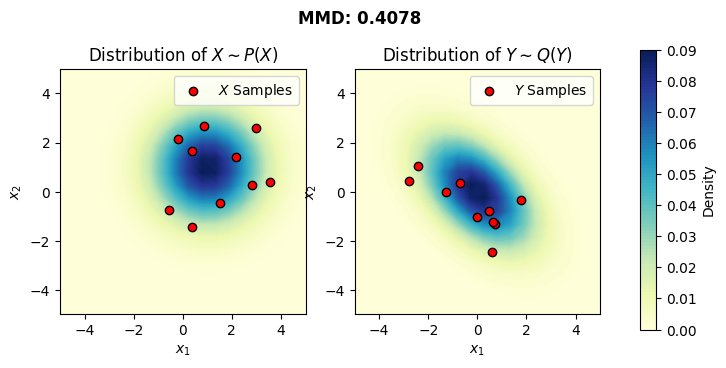

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=100)
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)
x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m, m)
qy_grid = torch.zeros(m, m)

for i in range(m):
    for j in range(m):
        px_grid[i, j] = multivariate_normal.pdf(np.array([x1[i, j], x2[i, j]]), mean=x_mean, cov=x_cov)
        qy_grid[i, j] = multivariate_normal.pdf(np.array([x1[i, j], x2[i, j]]), mean=y_mean, cov=y_cov)

ax1.contourf(x1, x2, px_grid, 100, cmap=plt.cm.YlGnBu)
ax1.set_title('Distribution of $X \sim P(X)$')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_aspect('equal')
ax1.scatter(x[:10, 0].cpu(), x[:10, 1].cpu(),
            label='$X$ Samples',
            marker='o',
            facecolor='r',
            edgecolor='k')
ax1.legend()

p2 = ax2.contourf(x1, x2, qy_grid, 100, cmap=plt.cm.YlGnBu)
ax2.set_title('Distribution of $Y \sim Q(Y)$')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10, 0].cpu(), y[:10, 1].cpu(),
            label='$Y$ Samples',
            marker='o',
            facecolor='r',
            edgecolor='k')
ax2.legend()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p2, cax=cbar_ax)
cbar.set_label('Density')
plt.suptitle(f'MMD: {result:.4f}', y=0.95, fontweight='bold')
plt.show()

In [6]:
root = '/'
batch_size = 500
input_dim = 32
output_dim = 784
epochs = 20
kernel = 'rbf'

In [7]:
# Generative with Maximum Mean Discrepancy (GMMD)
class GMMD(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GMMD, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 600)
        self.fc3 = nn.Linear(600, 1000)
        self.fc4 = nn.Linear(1000, output_dim)

    def forward(self, X):
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = torch.sigmoid(self.fc3(X))
        X = torch.sigmoid(self.fc4(X))
        return X

In [8]:
def train_one_step(x, samples, kernel, optimizer):
    samples = Variable(samples).to(device)
    preds = model(samples)

    loss = mmd(x, preds, kernel)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [9]:
%%time
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.EMNIST(root=root, split='digits', train=True, transform=transforms, download=True)
test_dataset = datasets.EMNIST(root=root, split='digits', train=False, transform=transforms, download=True)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)


model = GMMD(input_dim, output_dim).to(device)
try:
    model.load_state_dict(torch.load('gmmd.pth'))
    print('Model loaded successfully')
except:
    pass

optimizer = optim.RMSprop(model.parameters(), lr=0.004)

Model loaded successfully
CPU times: user 86.1 ms, sys: 362 ms, total: 448 ms
Wall time: 700 ms


<timed exec>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [10]:
def train(kernel='multiscale'):
    i = 0
    Z = torch.randn((5800, batch_size, input_dim))
    for epoch in range(epochs):
        avg_loss = 0
        resampling_limit = 300

        for idx, (x, _) in enumerate(train_loader):
            i += 1
            x = x.view(x.size(0), -1)
            x = Variable(x).to(device)

            random_noise = Z[idx, :, :]

            loss = train_one_step(x, random_noise, kernel, optimizer)
            avg_loss += loss.item()
            if i % 300 == 0:
                Z = random_noise = torch.randn((5800, batch_size, input_dim))

        avg_loss /= (idx + 1)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, avg_loss))

    torch.save(model.state_dict(), 'gmmd.pth')

In [11]:
def visualize():
    Z = random_noise = torch.randn((5800, batch_size, input_dim))

    view_data = [test_dataset[i][0] for i in range(4 * 8)]
    plt.gray()
    print('Images generated by GMMD:')
    for row in range(4):
        for col in range(8):
            plt.subplot(4, 8, row * 8 + col + 1)
            noise = torch.randn((1, input_dim)).to(device)
            y = model(noise)
            plt.imshow(y.detach().squeeze().cpu().reshape(28, 28))
            plt.axis('off')
    plt.show()

In [12]:
kernel = 'multiscale'
train()
visualize()

Epoch [1/20], Loss: 3.9390
Epoch [2/20], Loss: 3.9388
Epoch [3/20], Loss: 3.9388
Epoch [4/20], Loss: 3.9388
Epoch [5/20], Loss: 3.9388
Epoch [6/20], Loss: 3.9388


KeyboardInterrupt: 